# **KoBERT Model with fine tuning**

 - 2번분석, 발화 내용 기반 보이스피싱 발화문, 일반 상담 발화문 감정 판별

In [2]:
# # 원본 https://github.com/SKTBrain/KoBERT에 나와있는 using pytorch 코드
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [20]:
# # RUN
# 필요 import 문 
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np  # 'ersion : '1.23.5'
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# # 원본 https://github.com/SKTBrain/KoBERT에 나와있는 using pytorch 코드
# from kobert import get_tokenizer
# from kobert import get_pytorch_kobert_model

In [5]:
# # 원본 https://github.com/SKTBrain/KoBERT에 나와있는 using pytorch 코드
# bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

### HuggingFace 우회

In [6]:
# # RUN
# ModuleNotFoundError: No module named 'kobert'로 인한 허깅페이스 우회
# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [7]:
# # RUN
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

In [8]:
# # RUN
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

In [9]:
# RUN
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

2023-08-13 10:42:31.180823: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 10:42:31.220931: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 10:42:31.221998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 10:42:32.050234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# # RUN
# # 그래픽 카드 사용
print('torch version: {}'.format(torch.__version__))

if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

torch version: 1.10.1+cu102
현재 가상환경 GPU 사용 가능상태


In [11]:
# 사용하는 Graffic card 이름 확인
torch.cuda.is_available()
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080'

In [12]:
# GPU 용량 확인
# Get the current memory usage (in bytes)
allocated = torch.cuda.memory_allocated(device)
reserved = torch.cuda.memory_reserved(device)

# Convert to MB
allocated_mb = allocated / 1024 / 1024
reserved_mb = reserved / 1024 / 1024

print(f'Allocated memory: {allocated_mb:.2f} MB')
print(f'Reserved memory: {reserved_mb:.2f} MB')

Allocated memory: 0.00 MB
Reserved memory: 0.00 MB


### Loading Data and preprocessing

In [13]:
import os
os.getcwd()

'/KITA_Project'

In [14]:
# File pathS
file_path_data= "/KITA_Project/5차년도2차_수정.csv" # 필요에 따라 파일 경로 변경

df_emo = pd.read_csv(file_path_data, encoding='utf-8')

In [16]:
# label 확인

df_emo['상황'].unique()

array(['neutral', 'angry', 'disgust', 'fear'], dtype=object)

In [17]:
df_emo.head()

,발화문,상황
0,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,neutral
1,난 부페 형식의 음식들도 정말 좋아해. 그 것도 좀 알려 줘.,neutral
2,내가 좋아하는 유튜버가 좋은 제품이라고 하길래 나도 샀지. 그런데 그게 돈 받고 하...,angry
3,그래서 사람들이 증거 사진을 올렸더니 그 때서야 광고였다고 미안하다고 하는 거야.,angry
4,처음부터 자기 잘못을 알고 미안하다고 했으면 화가 이렇게 나진 않았을 거야. 사람들...,angry


In [18]:
df_emo['상황'].unique()

array(['neutral', 'angry', 'disgust', 'fear'], dtype=object)

/anaconda/envs/mldl_torch/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/anaconda/envs/mldl_torch/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54889 (\N{HANGUL SYLLABLE HWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


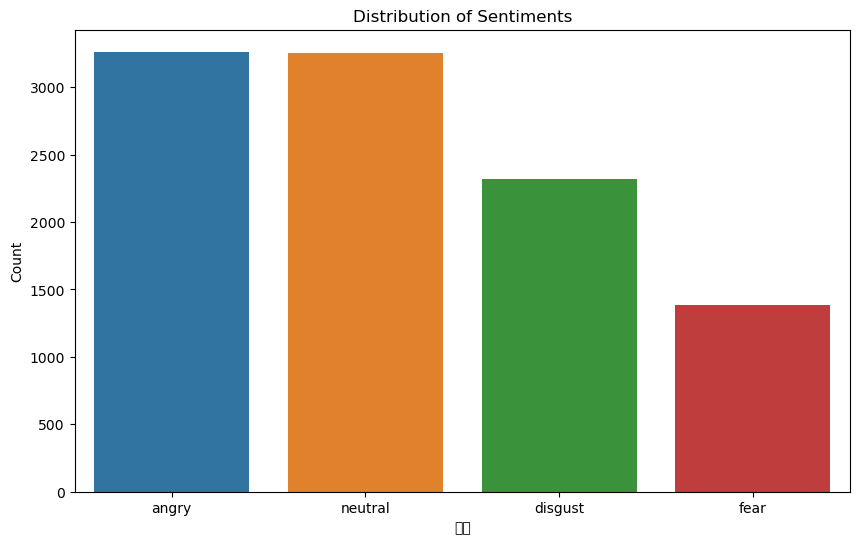

In [22]:
# Count the number of each sentiment
sentiment_counts = df_emo['상황'].value_counts()

# Create a barplot
plt.figure(figsize=(10,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Add title and labels
plt.title('Distribution of Sentiments')
plt.xlabel('상황')
plt.ylabel('Count')

# Show the plot
plt.show()


In [23]:
# Lableing

df_emo.loc[(df_emo['상황'] == "neutral"), '상황'] = 0 
df_emo.loc[(df_emo['상황'] == "angry"), '상황'] = 1 
df_emo.loc[(df_emo['상황'] == "disgust"), '상황'] = 2  
df_emo.loc[(df_emo['상황'] == "fear"), '상황'] = 3 

In [24]:
data_list= []
for q, label in zip(df_emo['발화문'], df_emo['상황'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [25]:
print(len(data_list))
print(data_list[0])
print(data_list[3000])
print(data_list[6000])
print(data_list[10000])

10223
['에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.', '0']
['따로 가서 서핑을 즐기려고 했지.', '1']
['몸은 괜찮은데 걱정이야.', '3']
['어. 보니까 쓰레기통에 버려뒀던 음식물 쓰레기가 그 사이 썩은 것 같애.', '2']


### Data Splitting

In [26]:
# Split data into training, validation, and testing sets
# Assuming data_list is your full data
dataset_train, dataset_temp = train_test_split(data_list, test_size=0.2, random_state=42, shuffle=True)
dataset_valid, dataset_test = train_test_split(dataset_temp, test_size=0.2, random_state=42, shuffle=True)
print(len(dataset_train))
print(len(dataset_valid))
print(len(dataset_test))


8178
1636
409


In [27]:
print(dataset_train[5])
print(dataset_valid[10])
print(dataset_test[15])

['나 오늘 대학교에 짭새가 몰려있어서 궁금해서 구경하고 왔어.', '0']
['습기가 많고 환기가 잘 되지 않는 거 같아서 매일 청소를 하는데 곰팡이가 안 없어져.', '1']
['지만, 그 분은 욕을 좀 먹어야 돼.', '1']


In [28]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, vocab, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [47]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 500
learning_rate =  5e-5

In [30]:
# Define your datasets
dataset_train = BERTDataset(dataset_train, 0, 1, tokenizer, max_len, vocab, True, False)
dataset_valid = BERTDataset(dataset_valid, 0, 1, tokenizer, max_len, vocab, True, False)
dataset_test = BERTDataset(dataset_test, 0, 1, tokenizer, max_len, vocab, True, False)

In [31]:
dataset_train[0]

(array([   2,  517, 6983,    5, 4396, 7178, 6198, 6903, 2309, 6050, 1396,
          54,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(13, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 2)

In [32]:
dataset_valid[0]

(array([   2,  806,  517, 6187, 7461, 5838, 4048, 7096, 1370, 5348, 6855,
          54,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(13, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 3)

In [33]:
dataset_test[0]

(array([   2, 1434, 7126, 4627, 6116, 1933, 5571, 5018,  517, 6249, 2010,
        6856, 4977, 7318, 2049, 5405, 6855,   54,    3,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(19, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 0)

In [34]:
# Define your dataloaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=5)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=5)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=5)

In [35]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=4,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [36]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [37]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [38]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [39]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.valid_score_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, valid_score, model):
        score = -valid_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(valid_score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(valid_score, model)
            self.counter = 0

    def save_checkpoint(self, valid_score, model):
        if self.verbose:
            self.trace_func(f'Validation score decreased ({self.valid_score_min:.6f} --> {valid_score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.valid_score_min = valid_score

### Model train

In [40]:
# Initialize lists for storing history
train_history = []
valid_history = []
test_history = []
loss_history = []
valid_loss_history = []
test_loss_history = []

# Initialize early_stopping object
early_stopping = EarlyStopping(patience=3, verbose=True, path='model_vp_classification.pt')

best_valid_acc = 0.0

# Training loop
for e in range(num_epochs):
    train_acc = 0.0
    train_loss = 0.0
    valid_acc = 0.0
    valid_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0
    model.train()  # Set the model to training mode

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        # Clear gradients
        optimizer.zero_grad()
        
        # Move tensors to the configured device
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)  # Forward pass

        loss = loss_fn(out, label)  # Compute the loss
        loss.backward()  # Perform backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Clip gradients
        optimizer.step()  # Update weights
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)  # Calculate accuracy

        if batch_id % log_interval == 0:
            print(f"epoch {e+1} batch id {batch_id+1} loss {loss.item()} train acc {train_acc / (batch_id+1)}")
            train_history.append(train_acc / (batch_id+1))  # Update training history
            loss_history.append(loss.item())  # Update loss history

    print(f"epoch {e+1} train acc {train_acc / (len(train_dataloader))}")
    train_loss /= len(train_dataloader)

    model.eval()  # Set the model to evaluation mode
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        with torch.no_grad():
            out = model(token_ids, valid_length, segment_ids)  # Forward pass
        loss = loss_fn(out, label)
        valid_loss += loss.item()
        valid_acc += calc_accuracy(out, label)  # Calculate accuracy

    print(f"epoch {e+1} valid acc {valid_acc / (len(valid_dataloader))}")
    valid_history.append(valid_acc / (len(valid_dataloader)))  # Update validation history
    valid_loss /= len(valid_dataloader)
    valid_loss_history.append(valid_loss)

    # If the validation accuracy of this epoch is better than before, save the model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), f'vp_sem_clf_model_{e+1}.pt')

    # Early stopping
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

  0%|          | 0/128 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.4280422925949097 train acc 0.234375
epoch 1 train acc 0.5095263671875


  0%|          | 0/26 [00:00<?, ?it/s]

epoch 1 valid acc 0.8519631410256411
Validation score decreased (inf --> 0.474595).  Saving model ...


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.511427640914917 train acc 0.84375
epoch 2 train acc 0.89654296875


  0%|          | 0/26 [00:00<?, ?it/s]

epoch 2 valid acc 0.9103899572649573
Validation score decreased (0.474595 --> 0.250310).  Saving model ...


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.2578696608543396 train acc 0.9375
epoch 3 train acc 0.937275390625


  0%|          | 0/26 [00:00<?, ?it/s]

epoch 3 valid acc 0.9206063034188035
Validation score decreased (0.250310 --> 0.228314).  Saving model ...


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.16292379796504974 train acc 0.953125
epoch 4 train acc 0.9556201171875


  0%|          | 0/26 [00:00<?, ?it/s]

epoch 4 valid acc 0.9262152777777778
EarlyStopping counter: 1 out of 3


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.042246706783771515 train acc 0.96875
epoch 5 train acc 0.9655078125


  0%|          | 0/26 [00:00<?, ?it/s]

epoch 5 valid acc 0.9149305555555555
EarlyStopping counter: 2 out of 3


  0%|          | 0/128 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.12535329163074493 train acc 0.953125
epoch 6 train acc 0.9745751953125


  0%|          | 0/26 [00:00<?, ?it/s]

epoch 6 valid acc 0.906784188034188
EarlyStopping counter: 3 out of 3
Early stopping


### Final Evaluation

In [41]:
# Finally, your testing code will be the same as before
model.eval()  # Set the model to evaluation mode
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length.to(device)
    label = label.long().to(device)

    with torch.no_grad():
        out = model(token_ids, valid_length, segment_ids)  # Forward pass
    loss = loss_fn(out, label)
    test_loss += loss.item()
    test_acc += calc_accuracy(out, label)  # Calculate accuracy

print(f"test acc {test_acc / (len(test_dataloader))}")
test_history.append(test_acc / (len(test_dataloader)))  # Update test history
test_loss /= len(test_dataloader)
test_loss_history.append(test_loss)



  0%|          | 0/7 [00:00<?, ?it/s]

test acc 0.9022321428571428


### Plotting training, validation data's Accuracy and Loss

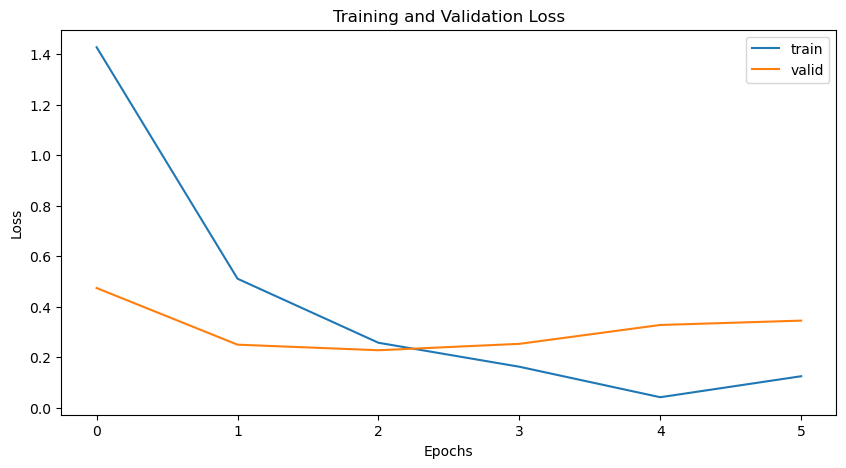

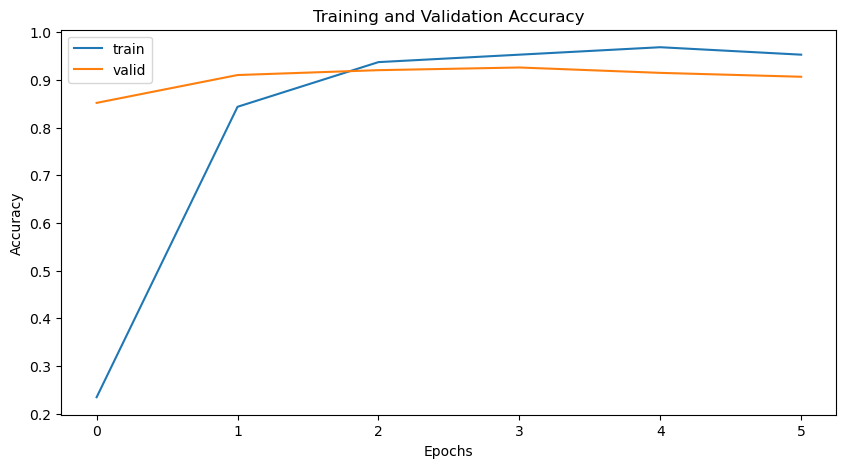

In [42]:
# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(loss_history, label="train")
plt.plot(valid_loss_history, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_history, label="train")
plt.plot(valid_history, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model Load & test evaluation

In [ ]:
# Load the best model
model_path = 'final_model_koBERT_vp_clf'  # adjust the path if needed
model.load_state_dict(torch.load(model_path))

# Initialize variables
test_acc = 0.0
test_loss = 0.0

# Set the model to evaluation mode
model.eval()

# Loop over test data
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length.to(device)
    label = label.long().to(device)

    # Make predictions
    with torch.no_grad():
        out = model(token_ids, valid_length, segment_ids)

    # Compute loss and accuracy
    loss = loss_fn(out, label)
    test_loss += loss.item()
    test_acc += calc_accuracy(out, label)

# Compute average test loss and accuracy
test_acc /= len(test_dataloader)
test_loss /= len(test_dataloader)

# Print results
print(f"test acc {test_acc}")
print(f"test loss {test_loss}")


## predict with real data

In [52]:
def predict(predict_sentence):
    data = [predict_sentence, '0']
    dataset_another = [data]
    
    # Define the maximum length for the tokens. You can adjust this value.
    max_len = 64
    
    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, max_len, vocab, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=1, num_workers=5)
    
    model.eval()
    
    sentiment_labels = ["중립", "화남", "역겨움", "두려움"]

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        probs = F.softmax(out, dim=1)  # Convert logits to probabilities

        # Get the predicted label and its probability
        predicted_label_idx = torch.argmax(out).item()
        predicted_label_prob = probs[0][predicted_label_idx].item() * 100  # Convert to percentage

        print(f">> 입력하신 문장은 {predicted_label_prob:.2f}%의 확률로 \"{sentiment_labels[predicted_label_idx]}\"감정이 느껴지는 문장입니다.")

# User input loop
end = 1
while end == 1:
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0":
        break
    predict(sentence)
    print("\n")


하고싶은 말을 입력해주세요 : 안녕하세요.
>> 입력하신 문장은 99.81%의 확률로 "중립"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 아니 내가 왜 해야해?
>> 입력하신 문장은 80.36%의 확률로 "화남"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 흠...
>> 입력하신 문장은 95.58%의 확률로 "중립"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 그러면 지금 스마트 뱅킹이나 인터넷 뱅킹을 사용하고 계신 건가요?
>> 입력하신 문장은 67.67%의 확률로 "화남"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 어플에서 가능합니다.
>> 입력하신 문장은 65.14%의 확률로 "화남"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 이용권에 따라 다릅니다.
>> 입력하신 문장은 86.54%의 확률로 "중립"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 궁금한 게 통장을 개설할 때 주민등록증하고 주민등록증하고 왜 본인이 같은 서울 영등포구 문래동 물래 지점에서 농협과 신한의 통장 결산하신 적 있습니까?
>> 입력하신 문장은 99.79%의 확률로 "중립"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 네, 쿠폰은 같이 드립니다. 단 삼 단계는 현재 재고가 다 소진되어 있습니다.
>> 입력하신 문장은 99.02%의 확률로 "화남"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 저희 농협 대출 나가면 그거 가지고 친구분한테 빌렸던 거 갚아주면 되는 거니까요.
>> 입력하신 문장은 97.43%의 확률로 "화남"감정이 느껴지는 문장입니다.


하고싶은 말을 입력해주세요 : 0
